# Looking into the cases for which the SELFIES v0 could not make a valid SMILES

In [39]:
import sys
sys.path.append('../../')
import net.evolution_functions as evo 
from sa_scorer.sascorer import calculate_score
import pandas as pd
from rdkit.Chem import Draw

In [40]:
def draw_multiple_mol(mols, mols_per_row=4, file_path=None, subImgSize=(300, 160)):
    mols_per_row = min(len(mols), mols_per_row)
    img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=subImgSize, useSVG=True)
    if file_path:
        with open(file_path, 'w') as f_handle:
            f_handle.write(img.data)
    return img

In [14]:
def calc_properties(smile):
    """Calculate logP for each molecule in unseen_smile_ls, and record results
    in locked dictionary props_collect
    """
 
    mol, smi_canon, did_convert = evo.sanitize_smiles(smile)
    logP = evo.get_logP(mol)  # Add calculation
    sas = calculate_score(mol)
    ring_penalty = calculate_ring_penalty(mol)
    return {
        'logP': logP, 
        'sas': sas, 
        'ring_penalty': ring_penalty
    }
    
def calculate_ring_penalty(mol):
    """Calculate Ring penalty for each molecule in unseen_smile_ls,
    results are recorded in locked dictionary props_collect
    """

    cycle_list = mol.GetRingInfo().AtomRings()
    if len(cycle_list) == 0:
        cycle_length = 0
    else:
        cycle_length = max([len(j) for j in cycle_list])
    if cycle_length <= 6:
        cycle_length = 0
    else:
        cycle_length = cycle_length - 6
    return cycle_length


def obtained_standardized_properties(
    logPs, SASs, ringPs
):
    """Obtain calculated properties of molecules in molecules_here, and standardize
    values base on properties of the Zinc Data set.
    """
    # Standardize logP based on zinc logP (mean: 2.4729421499641497 & std : 1.4157879815362406)
    logP_norm = (logPs - 2.4729421499641497) / 1.4157879815362406
    logP_norm = logP_norm.reshape((logPs.shape[0], 1))

    # Standardize SAS based on zinc SAS(mean: 3.0470797085649894    & std: 0.830643172314514)
    SAS_norm = (SASs - 3.0470797085649894) / 0.830643172314514
    SAS_norm = SAS_norm.reshape((SASs.shape[0], 1))

    # Standardize RingP based on zinc RingP(mean: 0.038131530820234766 & std: 0.2240274735210179)
    RingP_norm = (ringPs - 0.038131530820234766) / 0.2240274735210179
    RingP_norm = RingP_norm.reshape((ringPs.shape[0], 1))

    return (
        logP_norm,
        SAS_norm,
        RingP_norm,
    )




In [1]:
from selfies import decoder

In [3]:
with open('../../../random_baseline_failures', 'r') as fh:
    lines = fh.readlines()

In [31]:
smiles = []

for line in lines[:500000]:
    smiles.append(decoder(line.split(',')[0].strip()))

In [32]:
results = []
for smile in smiles:
    r = calc_properties(smile)
    r['smile'] = smile
    r['j'] = r['logP'] - r['sas'] - r['ring_penalty']
    
    results.append(r)

In [33]:
df = pd.DataFrame(results)

In [37]:
df['j'].mean()

-4.295424931372343

In [38]:
df['j'].std()

2.7279356989078627

In [36]:
df.head()

,logP,sas,ring_penalty,smile,j
0,1.21117,5.334323,0,FSC=N,-4.123153
1,5.47540,5.016846,0,N(=C)C=CC=C=C(C=CC=CC=C=C(C))C=C1C=CC=C1F,0.458554
2,1.51690,5.780200,0,C(=NSF)F,-4.263300
3,1.72070,6.076670,0,FS#CN=NOOF,-4.355970
4,4.04786,5.252103,0,FOCC=CC=C=C(OS#N)C=CC=CC=C(OF)C#N,-1.204243


In [43]:
mols_sample = []

for smile in smiles[:9]:
    mol, _, _ = evo.sanitize_smiles(smile)
    mols_sample.append(mol)

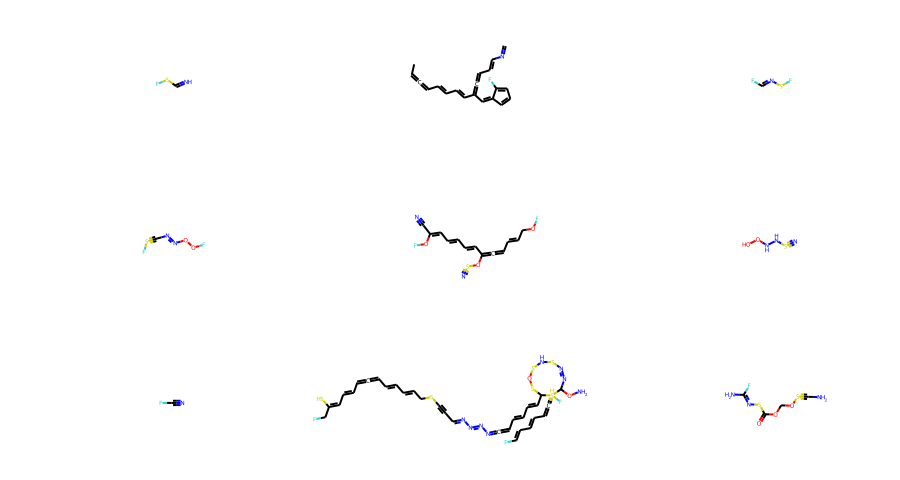

In [47]:
draw_multiple_mol(mols_sample, mols_per_row=3, file_path='random_smiles_failure.svg')